In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing,Standardizing
from sklearn.preprocessing import StandardScaler

#For Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Models
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

#Metrics
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [100]:
df=pd.read_excel('cars.xlsx')
df.head()

,Unnamed: 0,Brand,Model,Variant,Make Year,Fuel Type,Transmission,Kilometers Driven,Owner,Location,Price
0,0,maruti,Maruti Wagon R 1.0,VXI,2011,Petrol,Manual,"32,725",1,bengaluru,"3,39,299"
1,1,maruti,Maruti Alto 800,LXI,2016,Petrol,Manual,"16,134",1,bengaluru,"3,19,099"
2,2,maruti,Maruti Celerio,VXI AMT,2014,Petrol,Automatic,"13,928",1,bengaluru,"4,28,999"
3,3,maruti,Maruti Ritz,VXI BS IV,2013,Petrol,Manual,"41,507",1,bengaluru,"4,18,899"
4,4,maruti,Maruti Alto 800,LXI,2017,Petrol,Manual,"10,742",2,bengaluru,"3,51,799"


# EDA

In [41]:
df.shape

(8116, 11)

There are 8116 rows and 11 columns in the dataset

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         8116 non-null   int64 
 1   Brand              8116 non-null   object
 2   Model              8116 non-null   object
 3   Variant            8116 non-null   object
 4   Make Year          8116 non-null   int64 
 5   Fuel Type          8116 non-null   object
 6   Transmission       7836 non-null   object
 7   Kilometers Driven  8116 non-null   object
 8   Owner              8116 non-null   int64 
 9   Location           8116 non-null   object
 10  Price              8116 non-null   object
dtypes: int64(3), object(8)
memory usage: 697.6+ KB


There are null values in Transmission variable. We have int and object datatypes. Price is our target variable.

In [101]:
df['Transmission']=df['Transmission'].fillna(df['Transmission'].mode()[0])

We have filled the missing values

In [102]:
df['Kilometers Driven']=df['Kilometers Driven'].str.replace(',','')
df['Price']=df['Price'].str.replace(',','')

Removed the commas from the above two variables.

In [104]:
df['Kilometers Driven']=df['Kilometers Driven'].astype(int)
df['Price']=df['Price'].astype(int)

Converted the object datatype into int.

In [105]:
df.rename(columns={'Kilometers Driven':'KilometersDriven'},inplace=True)

In [106]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

Dropping unwanted columns

In [12]:
df['Fuel Type'].value_counts()

Petrol          5313
Diesel          2584
Petrol + CNG     211
Petrol + LPG       6
Electric           2
Name: Fuel Type, dtype: int64

In [107]:
df['Fuel Type']=df['Fuel Type'].replace(['Petrol + CNG'], 'CNG')
df['Fuel Type']=df['Fuel Type'].replace(['Petrol + LPG'], 'LPG')

In [108]:
df['Model']=df['Model'].str.split(" ").str.slice(1,3).str.join(' ')
df['Variant']=df['Variant'].str.split(" ").str.slice(0,2).str.join(' ')

Splitting to make our model more understandable.

In [109]:
df['Current Year']=2021
df['Car Age']=df['Current Year']-df['Make Year']
df.drop(['Make Year'],axis=1,inplace=True)
df.drop(['Current Year'],axis=1,inplace=True)
df.head()

,Brand,Model,Variant,Fuel Type,Transmission,KilometersDriven,Owner,Location,Price,Car Age
0,maruti,Wagon R,VXI,Petrol,Manual,32725,1,bengaluru,339299,10
1,maruti,Alto 800,LXI,Petrol,Manual,16134,1,bengaluru,319099,5
2,maruti,Celerio,VXI AMT,Petrol,Automatic,13928,1,bengaluru,428999,7
3,maruti,Ritz,VXI BS,Petrol,Manual,41507,1,bengaluru,418899,8
4,maruti,Alto 800,LXI,Petrol,Manual,10742,2,bengaluru,351799,4


Created a new variable in order to determine the age of the car.

In [17]:
df.describe()

,KilometersDriven,Owner,Price,Car Age
count,8.116000e+03,8116.000000,8.116000e+03,8116.000000
mean,-2.151625e+05,1.228438,5.720165e+05,4.956629
std,2.383798e+07,0.492266,3.520818e+05,2.674973
min,-2.147484e+09,1.000000,1.000000e+03,0.000000
25%,2.125800e+04,1.000000,3.527240e+05,3.000000
50%,4.064200e+04,1.000000,4.811490e+05,5.000000
75%,6.888325e+04,1.000000,6.672990e+05,7.000000
max,9.657030e+05,5.000000,4.490000e+06,19.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'maruti'),
  Text(1, 0, 'audi'),
  Text(2, 0, 'honda'),
  Text(3, 0, 'hyundai'),
  Text(4, 0, 'ford'),
  Text(5, 0, 'tata'),
  Text(6, 0, 'mahindra'),
  Text(7, 0, 'toyota'),
  Text(8, 0, 'chevrolet'),
  Text(9, 0, 'volkswagen'),
  Text(10, 0, 'renault'),
  Text(11, 0, 'skoda'),
  Text(12, 0, 'bmw'),
  Text(13, 0, 'nissan'),
  Text(14, 0, 'fiat'),
  Text(15, 0, 'datsun'),
  Text(16, 0, 'jeep'),
  Text(17, 0, 'mitsubishi'),
  Text(18, 0, 'kia'),
  Text(19, 0, 'mercedes-benz'),
  Text(20, 0, 'volvo'),
  Text(21, 0, 'mg')])

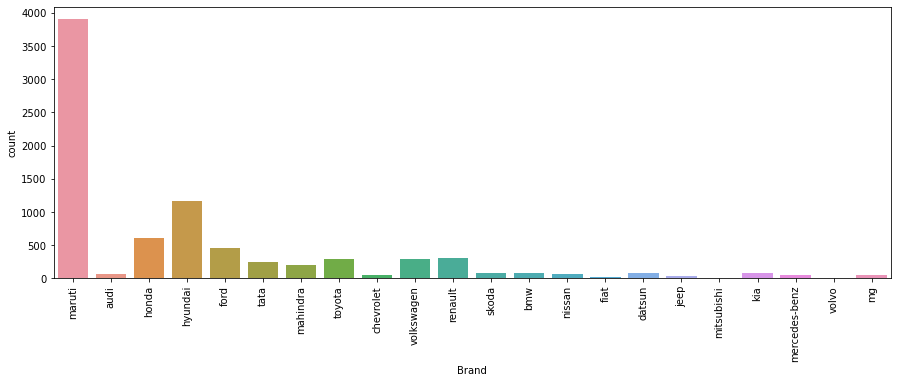

In [171]:
plt.figure(figsize=(15,5))
sns.countplot(df['Brand'])
plt.xticks(rotation = 90)

In [30]:
df['Location'].value_counts()

new-delhi      1203
pune            941
chandigarh      564
bengaluru       490
patna           482
chennai         464
ghaziabad       456
kochi           428
surat           348
nagpur          311
jaipur          294
gurgaon         287
mumbai          283
noida           267
ludhiana        207
nasik           188
hyderabad       186
faridabad       182
ahmedabad       155
vadodara        117
kolkata         112
lucknow          57
bhopal           36
rajkot           27
indore            9
dehradun          5
ranchi            5
agra              4
kanpur            4
allahabad         2
guwahati          1
bhubaneswar       1
Name: Location, dtype: int64

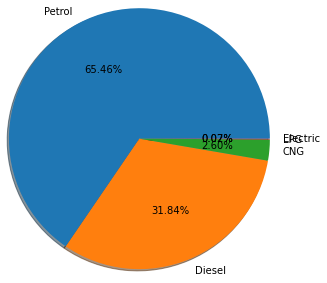

In [27]:
labels='Petrol','Diesel','CNG','LPG','Electric'

fig,ax=plt.subplots()
ax.pie(df['Fuel Type'].value_counts(),labels=labels,autopct='%1.2f%%',shadow=True,radius=1.5)

plt.show()

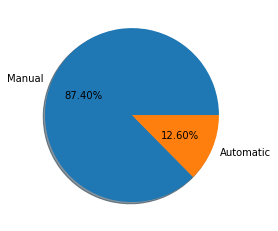

In [29]:
labels='Manual','Automatic'

fig,ax=plt.subplots()
ax.pie(df['Transmission'].value_counts(),labels=labels,autopct='%1.2f%%',shadow=True)

plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'bengaluru'),
  Text(1, 0, 'new-delhi'),
  Text(2, 0, 'noida'),
  Text(3, 0, 'gurgaon'),
  Text(4, 0, 'mumbai'),
  Text(5, 0, 'pune'),
  Text(6, 0, 'hyderabad'),
  Text(7, 0, 'chennai'),
  Text(8, 0, 'kolkata'),
  Text(9, 0, 'ahmedabad'),
  Text(10, 0, 'agra'),
  Text(11, 0, 'allahabad'),
  Text(12, 0, 'bhopal'),
  Text(13, 0, 'bhubaneswar'),
  Text(14, 0, 'indore'),
  Text(15, 0, 'jaipur'),
  Text(16, 0, 'kanpur'),
  Text(17, 0, 'lucknow'),
  Text(18, 0, 'nagpur'),
  Text(19, 0, 'patna'),
  Text(20, 0, 'ranchi'),
  Text(21, 0, 'surat'),
  Text(22, 0, 'vadodara'),
  Text(23, 0, 'chandigarh'),
  Text(24, 0, 'dehradun'),
  Text(25, 0, 'faridabad'),
  Text(26, 0, 'ghaziabad'),
  Text(27, 0, 'guwahati'),
  Text(28, 0, 'ludhiana'),
  Text(29, 0, 'nasik'),
  Text(30, 0, 'rajkot'),
  Text(31, 0, 'kochi')])

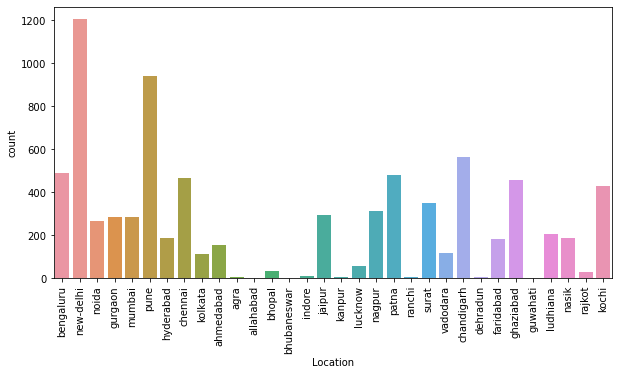

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(df['Location'])
plt.xticks(rotation = 90)

<AxesSubplot:xlabel='Car Age', ylabel='Price'>

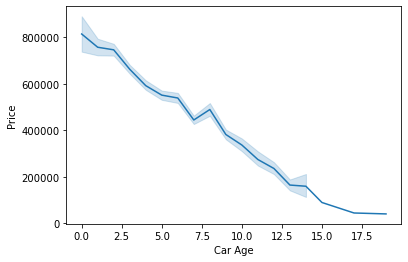

In [165]:
sns.lineplot(x='Car Age', y='Price', data=df)

<AxesSubplot:xlabel='Fuel Type', ylabel='Price'>

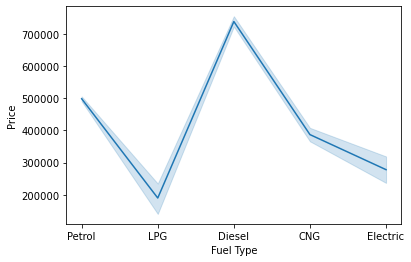

In [166]:
sns.lineplot(x='Fuel Type', y='Price', data=df)

<AxesSubplot:xlabel='Transmission', ylabel='Price'>

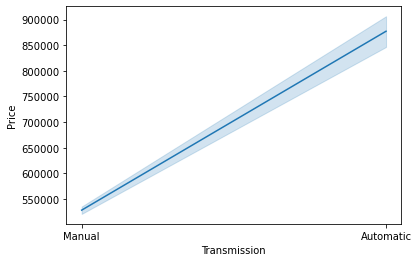

In [17]:
sns.lineplot(x='Transmission',y='Price',data=df)

<AxesSubplot:xlabel='Owner', ylabel='Price'>

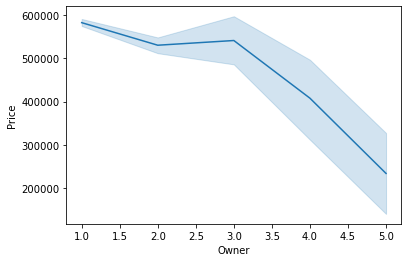

In [18]:
sns.lineplot(x='Owner',y='Price',data=df)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

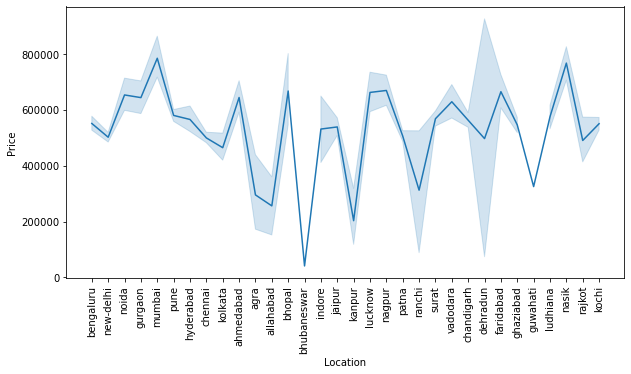

In [14]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Location',y='Price',data=df)
plt.xticks(rotation = 90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

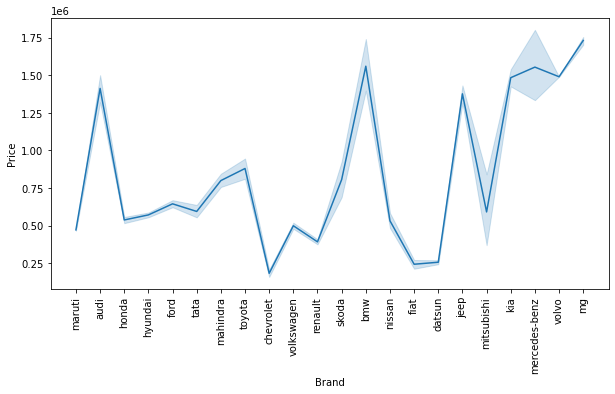

In [13]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Brand',y='Price',data=df)
plt.xticks(rotation = 90)

### From the above data visualizations:
1. Maruti, Hyundai and Honda are the most sold cars.
2. Petrol engine cars are most sold followed by diesel engine and CNG.
3. Manual Transmission cars are most sold.
4. States with most sold cars are New Delhi, Pune and Chandigarh.
5. Car price decreases with increase in car age.
6. Diesel cars are sold at higher prices whereas LPG is sold at lower price.
7. Automatic cars are sold at higher prices as compared to manual cars.
8. Car price decreases with increase in number of previous owners.
9. Cars in Mumbai, Nasik, Bhopal and Nagpur are sold at higher price whereas Bhubaneswar has the cheapest price for used cars.
10. Mg, BMW, Mercedes-benz are sold at higher price whereas Chevrolet, Fiat and Datsun are sold at lower price.

In [110]:
from sklearn.preprocessing import LabelEncoder

lab_enc=LabelEncoder()

df1=lab_enc.fit_transform(df['Brand'])
df2=lab_enc.fit_transform(df['Model'])
df3=lab_enc.fit_transform(df['Variant'])
df5=lab_enc.fit_transform(df['Fuel Type'])
df6=lab_enc.fit_transform(df['Transmission'])
df7=lab_enc.fit_transform(df['Location'])


df['Brand']=df1
df['Model']=df2
df['Variant']=df3
df['Fuel Type']=df5
df['Transmission']=df6
df['Location']=df7

Converted the categorical data into numerical data for our model to understand 

In [94]:
corr=df.corr()
corr.shape

(10, 10)

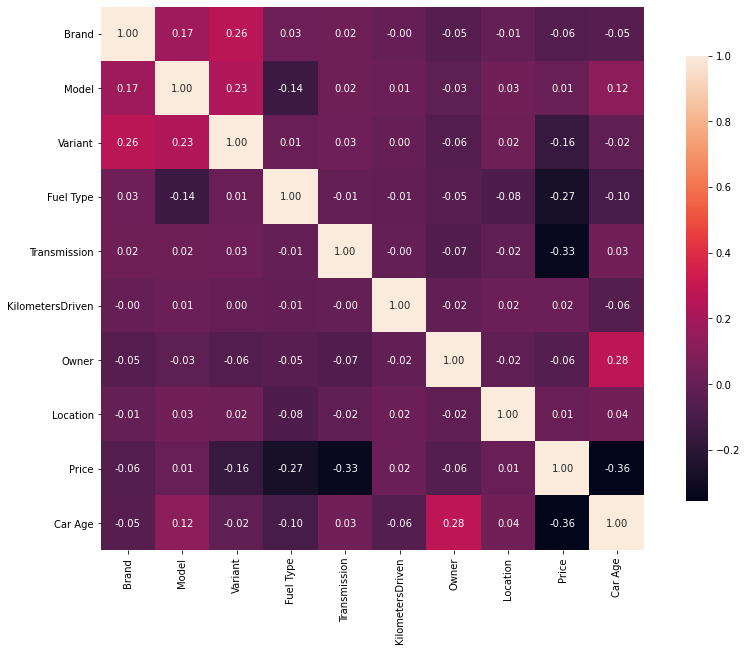

In [97]:
plt.figure(figsize=(15,10))

sns.heatmap(corr,cbar=True,square=True,cbar_kws={'shrink':0.82},fmt='.2f',annot=True,annot_kws={'size':10})
plt.show()

We find no multicolinearity issues in our dataset

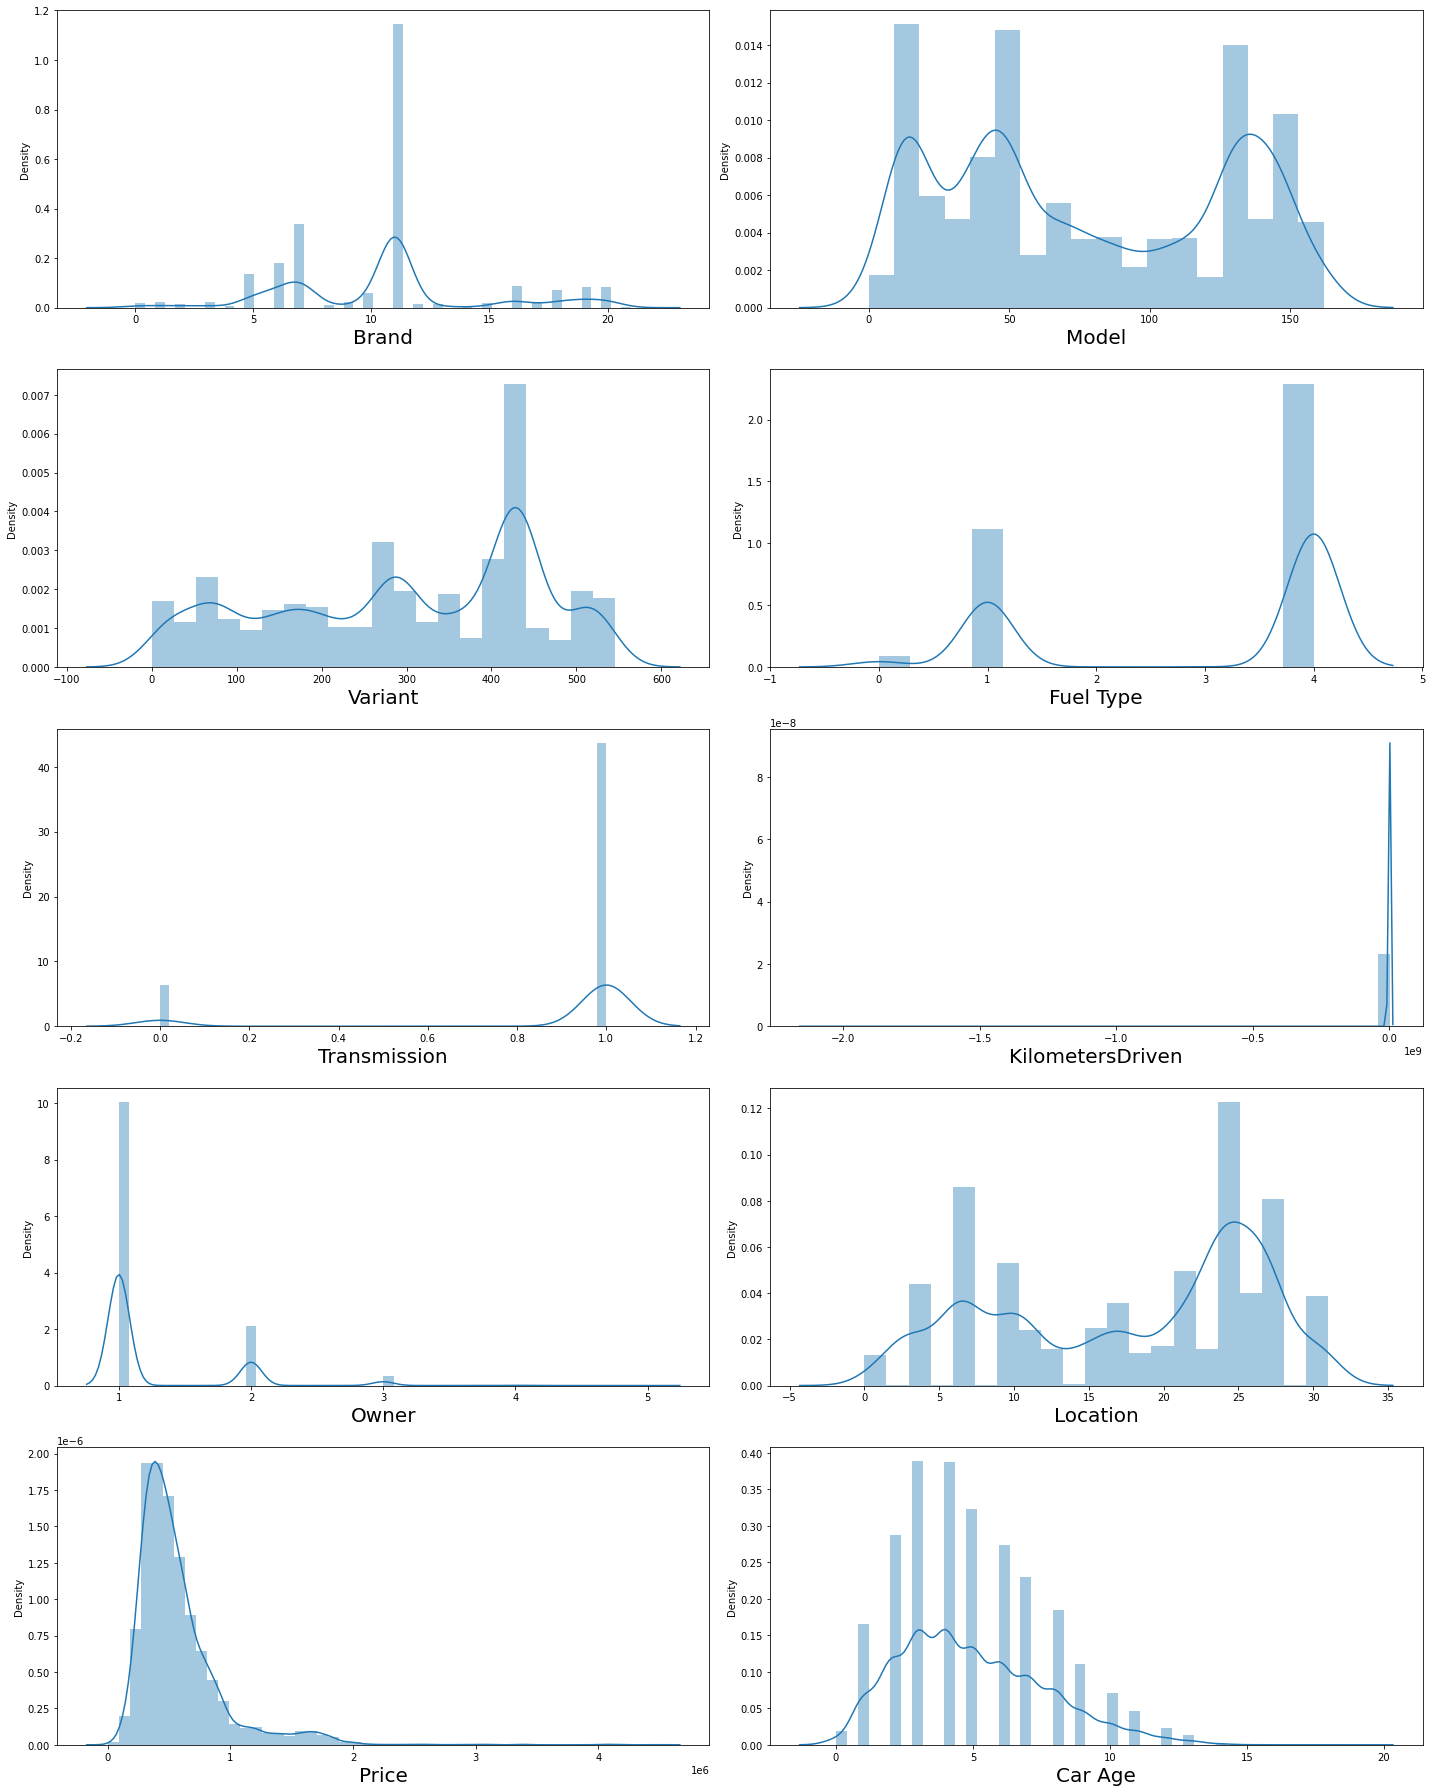

In [53]:
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1

for column in df:
    if plotnumber<=10:
        ax=plt.subplot(5,2,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=20)
    
    plotnumber+=1
plt.tight_layout()

We find skewness only in the KilometersDriven since it is the only numerical data in our dataset.

### FInding outliers and removal

<AxesSubplot:xlabel='KilometersDriven'>

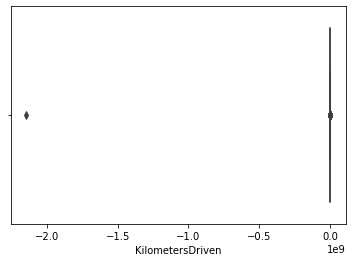

In [36]:
sns.boxplot(df['KilometersDriven'])

In [111]:
#Find the IQR (inter quantile range) to identify outliers

q1=df.quantile(0.25) #1st quantile

q3=df.quantile(0.75) #3rd quantile

#IQR
iqr=q3-q1
iqr

Brand                    4.00
Model                   94.00
Variant                267.00
Fuel Type                3.00
Transmission             0.00
KilometersDriven     47625.25
Owner                    0.00
Location                15.00
Price               314575.00
Car Age                  4.00
dtype: float64

In [112]:
index=np.where(df['KilometersDriven']>(q3.KilometersDriven)+(1.5*iqr.KilometersDriven))
df=df.drop(df.index[index])
print('Shape:',df.shape)
df.reset_index()

Shape: (7897, 10)


,index,Brand,Model,Variant,Fuel Type,Transmission,KilometersDriven,Owner,Location,Price,Car Age
0,0,11,146,433,4,1,32725,1,3,339299,10
1,1,11,12,283,4,1,16134,1,3,319099,5
2,2,11,34,441,4,0,13928,1,3,428999,7
3,3,11,114,443,4,1,41507,1,3,418899,8
4,4,11,12,283,4,1,10742,2,3,351799,4
...,...,...,...,...,...,...,...,...,...,...,...
7892,8111,16,133,312,4,1,6410,1,17,622499,1
7893,8112,16,86,314,4,1,32914,1,17,281999,5
7894,8113,3,113,6,4,1,19163,2,17,326799,3
7895,8114,8,40,272,1,1,20230,2,17,1692399,4


In [113]:
index=np.where(df['KilometersDriven']<(q1.KilometersDriven)-(1.5*iqr.KilometersDriven))
df=df.drop(df.index[index])
print('Shape:',df.shape)
df.reset_index()

Shape: (7896, 10)


,index,Brand,Model,Variant,Fuel Type,Transmission,KilometersDriven,Owner,Location,Price,Car Age
0,0,11,146,433,4,1,32725,1,3,339299,10
1,1,11,12,283,4,1,16134,1,3,319099,5
2,2,11,34,441,4,0,13928,1,3,428999,7
3,3,11,114,443,4,1,41507,1,3,418899,8
4,4,11,12,283,4,1,10742,2,3,351799,4
...,...,...,...,...,...,...,...,...,...,...,...
7891,8111,16,133,312,4,1,6410,1,17,622499,1
7892,8112,16,86,314,4,1,32914,1,17,281999,5
7893,8113,3,113,6,4,1,19163,2,17,326799,3
7894,8114,8,40,272,1,1,20230,2,17,1692399,4


### Finding skewness and removal

In [57]:
df.skew()

Brand               0.422427
Model               0.168025
Variant            -0.363732
Fuel Type          -0.759906
Transmission       -2.261232
KilometersDriven    0.727635
Owner               2.212310
Location           -0.398069
Price               2.766919
Car Age             0.616359
dtype: float64

In [114]:
df['KilometersDriven']=np.sqrt(df['KilometersDriven'])

In [100]:
df.skew()

Brand               0.422427
Model               0.168025
Variant            -0.363732
Fuel Type          -0.759906
Transmission       -2.261232
KilometersDriven    0.042875
Owner               2.212310
Location           -0.398069
Price               2.766919
Car Age             0.616359
dtype: float64

## Model Building

In [115]:
X=df.drop(columns=['Price'],axis=1)
y=df['Price']

We have separated the independent and dependent variables

In [116]:
#Standardizing

scaler=StandardScaler()
X_scaler=scaler.fit_transform(X)

#Checking multicollinearity by vif

vif=pd.DataFrame()
vif['score']=[variance_inflation_factor(X_scaler,i) for i in range(X_scaler.shape[1])]
vif['Features']=X.columns

vif

,score,Features
0,1.112037,Brand
1,1.112863,Model
2,1.126585,Variant
3,1.344592,Fuel Type
4,1.008990,Transmission
5,1.892226,KilometersDriven
6,1.100555,Owner
7,1.010398,Location
8,1.623047,Car Age


As seen in the heatmap, we find no multicolinearity issues

### Finding the best random state

In [103]:
maxAccu=0
maxRs=0
for i in range(1,200):
    X_train,x_test,Y_train,y_test=train_test_split(X_scaler,y,test_size=0.25,random_state=i)
    mod=DecisionTreeRegressor()
    mod.fit(X_train,Y_train)
    pred=mod.predict(x_test)
    acc=r2_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRs=i
print("Best accuracy is:",maxAccu,"on Random State",maxRs)

Best accuracy is: 0.9563108275930007 on Random State 152


In [117]:
X_train,x_test,Y_train,y_test=train_test_split(X_scaler,y,test_size=0.25,random_state=152)

### Evaluating different models

In [105]:
DTR=DecisionTreeRegressor()
DTR.fit(X_train,Y_train)
pred=DTR.predict(x_test)
print(r2_score(y_test,pred))

0.9557916219536722


In [107]:
RFR=RandomForestRegressor()
RFR.fit(X_train,Y_train)
pred=RFR.predict(x_test)
print(r2_score(y_test,pred))

0.9496894340916135


In [108]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor()
knn.fit(X_train,Y_train)
pred=knn.predict(x_test)
print(r2_score(y_test,pred))

0.664721177973995


In [109]:
from sklearn.ensemble import AdaBoostRegressor
ada=AdaBoostRegressor()
ada.fit(X_train,Y_train)
pred=ada.predict(x_test)
print(r2_score(y_test,pred))

0.2082364754711412


In [110]:
from sklearn.ensemble import GradientBoostingRegressor
gbc=GradientBoostingRegressor()
gbc.fit(X_train,Y_train)
pred=gbc.predict(x_test)
print(r2_score(y_test,pred))

0.8596503597902009


### Cross validation

In [111]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(DTR,X_scaler,y,cv=5).mean())
print(cross_val_score(RFR,X_scaler,y,cv=5).mean())
print(cross_val_score(knn,X_scaler,y,cv=5).mean())
print(cross_val_score(ada,X_scaler,y,cv=5).mean())
print(cross_val_score(gbc,X_scaler,y,cv=5).mean())

0.8016441993510671
0.8847541612102676
0.48397066087602614
-0.013534065156029996
0.7852188681677597


By comparing the r2 score and cross validation scores, we find Random Forest Regressor as our best model

### Hyperparameter Tuning

In [115]:
parameters={'n_estimators':[200,300,400,500,600,700],
           'max_features':['auto','sqrt','log2'],
           'criterion':['squared_error','absolute_error','poisson'],
           'max_depth':[5,10,15,20,25],
            'min_samples_leaf': [1, 2, 4, 6],
           'n_jobs':[-1]}

In [116]:
GCV=GridSearchCV(RandomForestRegressor(),parameters,cv=5)

In [117]:
GCV.fit(X_train,Y_train)

ERROR:concurrent.futures:exception calling callback for <Future at 0x17aa0760 state=finished raised KeyError>
Traceback (most recent call last):
  File "C:\Users\delkl\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\delkl\anaconda3\lib\site-packages\joblib\parallel.py", line 366, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\delkl\anaconda3\lib\site-packages\joblib\parallel.py", line 799, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\delkl\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\delkl\anaconda3\lib\site-packages\joblib\parallel.py", line 784, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\delkl\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunctio

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'n_estimators': [200, 300, 400, 500, 600, 700],
                         'n_jobs': [-1]})

In [133]:
GCV.best_params_

{'criterion': 'poisson',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500,
 'n_jobs': -1}

In [118]:
Final_model=RandomForestRegressor(min_samples_leaf=1,n_estimators=500,max_features='sqrt',criterion='poisson',max_depth=25,n_jobs=-1)
Final_model.fit(X_train,Y_train)
pred=Final_model.predict(x_test)
acc=r2_score(y_test,pred)
print('Accuracy:',acc*100)

Accuracy: 85.28221303796855


Looks like our model was overfitted. The new accuracy is 85%

Text(0, 0.5, 'Predicted')

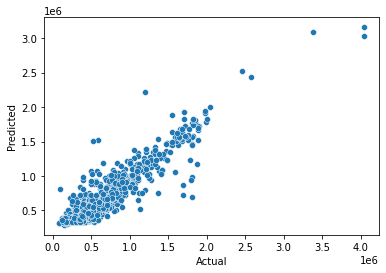

In [128]:
plt.figure()
sns.scatterplot(y_test, pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [119]:
import joblib
joblib.dump(Final_model,"UsedCarPrice.pkl")

['UsedCarPrice.pkl']